<center><p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<center><h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# <center>Домашнее задание. CycleGAN Pytorch

Выполнил: Дмитрий Шерешевский, ID 36196483
(Dmitry Shereshevskiy)

### Введение
Архитектуры подробно изложены в https://arxiv.org/pdf/1703.10593.pdf (1) и https://arxiv.org/pdf/1603.08155.pdf (2). Реализованная здесь архитектура полностью соответствует описаниям в статьях.    
Для дискриминатора использована упомянутая в статьях архтектура Markovian discriminator (PatchGAN). Его идею можно посмотреть, в частности, [здесь](https://www.researchgate.net/figure/The-patchGAN-discriminator-input-of-discriminator-is-either-the-pair-of-sketch-yellow_fig2_325291567).    
Было изучено несколько реализаций CycleGAN, в том числе и на соответствие принципам, изложенным в исходниках (1) и (2). Некоторые идеи для реализации отдельных частей архитектур, которые показались удачными и соответствующими исходным статьям, взяты отсюда https://github.com/aitorzip/PyTorch-CycleGAN, дабы не изобретать велосипед. Код адаптирован, значительно переработан и дополнен.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
os.chdir("gdrive/MyDrive/Colab Notebooks/DLSchool_mipt_1sem/cycleGAN/")

## Для начала решим вопрос с датасетом.   
**Для отладки** в этой работы использовались датасеты из репозитория **UC Berkeley**:    
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/


#### Имена датасетов в репозитории:    
apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos


### download dataset

In [ ]:
dataset_name = "horse2zebra"

Для скачивания датасета необходимо раскоментить следующую ячейку при первом прохождении ноутбука.   
В настоящий момент ячейка закоментина, чтобы не скачивать при отладке одни и те же файлы.

In [ ]:
# URL = f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{dataset_name}.zip"
# if not os.path.exists('datasets'):
#     os.mkdir('datasets')
# ZIP_FILE = f"./datasets/{dataset_name}.zip"
# TARGET_DIR = f"./datasets/{dataset_name}"
# ! mkdir -p ./datasets
# ! wget -N $URL -O $ZIP_FILE
# ! unzip $ZIP_FILE -d ./datasets/
# ! rm $ZIP_FILE

## Теперь сформируам наш **уникальный** датасет. 
Попросту скачаем вручную картинки черных и белых кошек и разложим по соответствующим папкам.

In [ ]:
dataset_name = "whitecat2blackcat"

In [ ]:
import glob
import random
import os

from torch.utils.data import Dataset, DataLoader, RandomSampler
from PIL import Image
import torchvision.transforms as transforms
import torch
import sys
import numpy as np
from torchvision.utils import save_image

import matplotlib.pyplot as plt

import itertools
import json

## класс для Dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode

        self.files_A = sorted(glob.glob(os.path.join(root, f'{mode}A', '*.*')))
        self.files_B = sorted(glob.glob(os.path.join(root, f'{mode}B', '*.*')))
    
    def to3channs(self, image):
        num_channels = len(image.split())
        if num_channels == 1:
            image = Image.merge("RGB", [image] * 3)
        return image
    
    def __getitem__(self, index):
        image = self.to3channs(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))
        item_A = self.transform(image)

        if self.mode == "train":
            if self.unaligned:
                image = self.to3channs(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
                item_B = self.transform(image)
            else:
                image = self.to3channs(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))
                item_B = self.transform(image)
        
        elif self.mode == "test":
            image = self.to3channs(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))
            item_B = self.transform(image)
        
        else:
            raise ValueError("The parameter 'mode' should only be 'train' or 'test'.")

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

### посмотрим на некоторые изображения тестового датасета

In [ ]:
size = 256
test_transforms = [transforms.Resize(int(size),  Image.BICUBIC),
                   transforms.CenterCrop(size),
                   transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataset = ImageDataset(f"datasets/{dataset_name}", test_transforms, mode="test")

In [ ]:
def plot_dataset(dataset, inds=tuple(range(6))):
    plt.figure(figsize=(18, 6))
    for i in inds:
        plt.subplot(2, len(inds), i+1)
        plt.axis("off")
        plt.imshow(0.5 * (test_dataset[i]["A"].numpy().transpose((1, 2, 0)) + 1))
        plt.title("real_A")

        plt.subplot(2, len(inds), i+7)
        plt.axis("off")
        plt.imshow(0.5 * (test_dataset[i]["B"].numpy().transpose((1, 2, 0)) + 1))
        plt.title("real_B")
    plt.show()

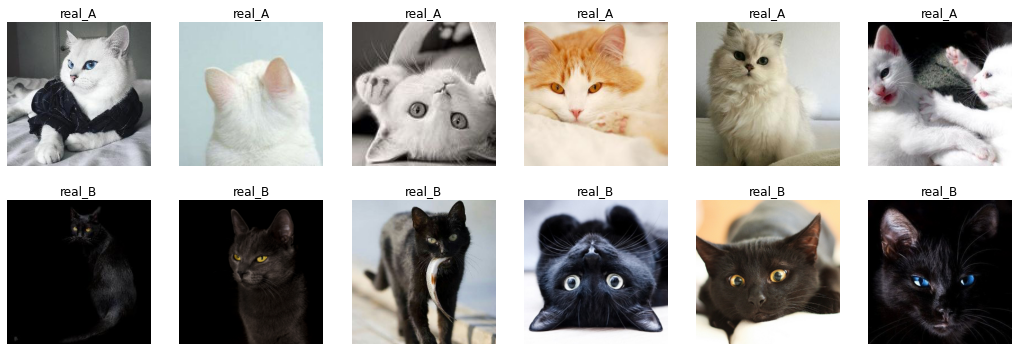

In [ ]:
plot_dataset(test_dataset)

### Модели

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3), 
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super().__init__()

        # Initial convolution block       
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, 64, 7),
                 nn.InstanceNorm2d(64),
                 nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]

            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, output_nc, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# for discriminator was used Markovian discriminator (PatchGAN) with the average pooling as output 
class PatchlBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        conv_block = [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features), 
                      nn.LeakyReLU(0.2, inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = []
        model += [PatchlBlock(input_nc, 64), 
                  PatchlBlock(64, 128), 
                  PatchlBlock(128, 256), 
                  PatchlBlock(256, 512)]
        # to one channel for the next average pooling
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.shape[2:]).view(x.shape[0], -1)

In [ ]:
class ImageBuffer:
    def __init__(self, max_size=50):
        if max_size < 0:
            print('Warning: Empty buffer or trying to create a black hole. Be careful.')
        self.max_size = max_size
        self.data = []

    def update(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class LambdaLR:
    def __init__(self, n_epochs, offset=0, decay_start_epoch=100):
        if (n_epochs - decay_start_epoch) < 0:
            print("Warning: Decay must start before the training session ends!")
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

#### функция для отрисовки тестовых картинок при обучении

In [ ]:
def plot_images(images: dict):
    img_len = len(images)
    fig, axes = plt.subplots(ncols=img_len, figsize=(9, img_len))
    for i, img_name in enumerate(images):
        ax = axes[i]
        ax.axis("off")
        img = 0.5 * (images[img_name].cpu().detach().numpy().transpose((1, 2, 0)) + 1)
        ax.imshow(img)
        ax.set_title(img_name)
    plt.show()

## Функции **train** и **test** - обучение и тестирование во время обучения

In [ ]:
def train(netG_A2B, netG_B2A, netD_A, netD_B, dataloader, epoch, plot_images_=False, plot_img_step=10, log=None):
    mode = "TRAIN"
    epoch_log = {}
    lambda_ = 10
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * 0.5*lambda_
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * 0.5*lambda_

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_

        # Total loss
        loss_G =  (loss_identity_A + loss_identity_B) + (loss_GAN_A2B + loss_GAN_B2A) + (loss_cycle_ABA + loss_cycle_BAB)
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.update(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake) / 2
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.update(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) / 2
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # epoch_log
        epoch_log["loss_G"] = epoch_log.get("loss_G", 0) + loss_G.item()
        epoch_log["loss_G_identity"] = epoch_log.get("loss_G_identity", 0) + (loss_identity_A + loss_identity_B).item()
        epoch_log["loss_G_GAN"] = epoch_log.get("loss_G_GAN", 0) + (loss_GAN_A2B + loss_GAN_B2A).item()
        epoch_log["loss_G_cycle"] = epoch_log.get("loss_G_cycle", 0) + (loss_cycle_ABA + loss_cycle_BAB).item()
        epoch_log["loss_D"] = epoch_log.get("loss_D", 0) + (loss_D_A + loss_D_B).item()
    
        if i == 0 and epoch == 0:
            print("Init images")
            images={'real_A': real_A[0], 'fake_B': fake_B[0], 'real_B': real_B[0], 'fake_A': fake_A[0]}
            plot_images(images)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()  

    # logs update
    for loss_item in log:
        epoch_log[loss_item] /= len(dataloader)
        log[loss_item].append(epoch_log[loss_item])
    
    # log print
    loss_line = ", ".join([f"{loss_item}: {epoch_log[loss_item]:.4f}" for loss_item in epoch_log])
    log_line = f"{mode} - {loss_line}"
    print(log_line)
    if plot_images_:
        if (epoch + 1) % plot_img_step == 0:
            images={'real_A': real_A[0], 'fake_B': fake_B[0], 'real_B': real_B[0], 'fake_A': fake_A[0]}
            plot_images(images)
    
    # Save models checkpoints and log
    if not os.path.exists(f'output/{output_name}'):
        os.makedirs(f'output/{output_name}')


    torch.save(netG_A2B.state_dict(), f'output/{output_name}/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), f'output/{output_name}/netG_B2A.pth')
    torch.save(netD_A.state_dict(), f'output/{output_name}/netD_A.pth')
    torch.save(netD_B.state_dict(), f'output/{output_name}/netD_B.pth')

    with open(f"output/{output_name}/train_log.json", "w") as file:
        json.dump(log, file)

In [ ]:
def test(netG_A2B, netG_B2A, netD_A, netD_B, dataloader, epoch, plot_images_=False, plot_img_step=10, log=None):
    mode = "TEST"
    epoch_log = {}
    lambda_ = 10
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        ###### Generators A2B and B2A ######
        with torch.no_grad():
            # Identity loss
            # G_A2B(B) should equal B if real B is fed
            same_B = netG_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B) * 0.5 * lambda_
            # G_B2A(A) should equal A if real A is fed
            same_A = netG_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A) * 0.5 * lambda_

            # GAN loss
            fake_B = netG_A2B(real_A)
            pred_fake = netD_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

            fake_A = netG_B2A(real_B)
            pred_fake = netD_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            recovered_A = netG_B2A(fake_B)
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_

            recovered_B = netG_A2B(fake_A)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_

            # Total loss
            loss_G =  (loss_identity_A + loss_identity_B) + (loss_GAN_A2B + loss_GAN_B2A) + (loss_cycle_ABA + loss_cycle_BAB)
            
            ###################################

            ###### Discriminator A ######

            # Real loss
            pred_real = netD_A(real_A)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            pred_fake = netD_A(fake_A.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake) / 2

            ###################################

            ###### Discriminator B ######
            # Real loss
            pred_real = netD_B(real_B)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            # Fake loss
            pred_fake = netD_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake) / 2
            ###################################

            # epoch_log
            epoch_log["loss_G"] = epoch_log.get("loss_G", 0) + loss_G.item()
            epoch_log["loss_G_identity"] = epoch_log.get("loss_G_identity", 0) + (loss_identity_A + loss_identity_B).item()
            epoch_log["loss_G_GAN"] = epoch_log.get("loss_G_GAN", 0) + (loss_GAN_A2B + loss_GAN_B2A).item()
            epoch_log["loss_G_cycle"] = epoch_log.get("loss_G_cycle", 0) + (loss_cycle_ABA + loss_cycle_BAB).item()
            epoch_log["loss_D"] = epoch_log.get("loss_D", 0) + (loss_D_A + loss_D_B).item()

    # logs update
    for loss_item in log:
        epoch_log[loss_item] /= len(dataloader)
        log[loss_item].append(epoch_log[loss_item])
    
    # log print and plot of images
    loss_line = ", ".join([f"{loss_item}: {epoch_log[loss_item]:.4f}" for loss_item in epoch_log])
    log_line = f"{mode} -  {loss_line}"
    print(log_line)
    if plot_images_:
        if (epoch + 1) % plot_img_step == 0:
            images={'real_A': real_A[0], 'fake_B': fake_B[0], 'real_B': real_B[0], 'fake_A': fake_A[0]}
            plot_images(images)

    # Save log and the best G models
    if not os.path.exists(f'output/{output_name}/best'):
        os.makedirs(f'output/{output_name}/best')

    with open(f"output/{output_name}/test_log.json", "w") as file:
        json.dump(log, file)

    if log["loss_G"][-1] <= min(log["loss_G"]):
        torch.save(netG_A2B.state_dict(), f'output/{output_name}/best/netG_A2B.pth')
        torch.save(netG_B2A.state_dict(), f'output/{output_name}/best/netG_B2A.pth')

### инициализация для обучения - параметры, классы моделей и таргеты

In [ ]:
# params init
n_epochs = 200  # number of epochs of training
batchSize = 3  # size of the batches
dataroot = f'datasets/{dataset_name}/'  # root directory of the dataset
lr = 0.0002  # initial learning rate
decay_epoch = 100  # epoch to start linearly decaying the learning rate to 0
size = 256  # size of the data crop (squared assumed)
input_nc = 3  # number of channels of input data
output_nc = 3  # number of channels of output data
n_cpu = 8  # number of cpu threads to use during batch generation

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, decay_start_epoch=decay_epoch).step)

# Inputs
target_real = torch.ones(batchSize, 1, requires_grad=False).to(device)
target_fake = torch.zeros(batchSize, 1, requires_grad=False).to(device)

fake_A_buffer = ImageBuffer()
fake_B_buffer = ImageBuffer()

#### инициализация даталоадеров

In [ ]:
# Dataset loaders
num_samples =300  # датасет ограниченный

train_transforms = [transforms.Resize(int(size*1.12),  Image.BICUBIC), 
                    transforms.RandomCrop(size), 
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
train_dataset = ImageDataset(dataroot, transforms_=train_transforms, unaligned=True)
train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=num_samples)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler,
                        batch_size=batchSize, num_workers=n_cpu, drop_last=True)

test_transforms = [transforms.Resize(int(size),  Image.BICUBIC),
                   transforms.CenterCrop(size), 
                   transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataloader = DataLoader(ImageDataset(dataroot, transforms_=test_transforms, unaligned=False, mode="test"), 
                        batch_size=batchSize, shuffle=True, num_workers=n_cpu, drop_last=True)

## непосредственно обучение
выводим на каждой эпохе информацию о лоссах и текущие тестовые картинки 

In [ ]:
output_name = f"{dataset_name}_s{size}_ns{num_samples}_bs{batchSize}"

In [ ]:
def train_loop(from_checkpoint=False):
    start_epoch = 0
    # инициализация loss-логов
    losses = ['loss_G', 'loss_G_identity', 'loss_G_GAN', 'loss_G_cycle', 'loss_D']
    train_log = {loss: [] for loss in losses}
    test_log = {loss: [] for loss in losses}

    if from_checkpoint:
        with open(f"output/{output_name}/train_log.json", "r") as file:
            train_log = json.load(file)
        with open(f"output/{output_name}/test_log.json", "r") as file:
            test_log = json.load(file)
        
        start_epoch = len(train_log["loss_G"])

        # load state dicts
        netG_A2B.load_state_dict(torch.load(f'output/{output_name}/netG_A2B.pth', map_location=device))
        netG_B2A.load_state_dict(torch.load(f'output/{output_name}/netG_B2A.pth', map_location=device))
        netD_A.load_state_dict(torch.load(f'output/{output_name}/netD_A.pth', map_location=device))
        netD_B.load_state_dict(torch.load(f'output/{output_name}/netD_B.pth', map_location=device))
    
    for epoch in range(start_epoch, n_epochs):
        print(f"Epoch - {epoch+1}")
        netG_A2B.train()
        netG_B2A.train()
        netD_A.train()
        netD_B.train()
        train(netG_A2B, netG_B2A, netD_A, netD_B, train_dataloader, epoch, log=train_log)
        netG_A2B.eval()
        netG_B2A.eval()
        netD_A.eval()
        netD_B.eval()
        test(netG_A2B, netG_B2A, netD_A, netD_B, test_dataloader, epoch, plot_images_=True, log=test_log)

Epoch - 1
Init images


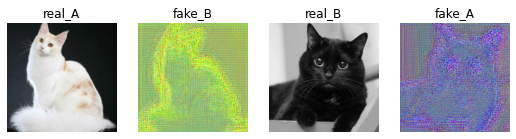

TRAIN - loss_G: 10.3229, loss_G_identity: 2.9785, loss_G_GAN: 1.0034, loss_G_cycle: 6.3410, loss_D: 0.3903
TEST -  loss_G: 9.0135, loss_G_identity: 2.6900, loss_G_GAN: 1.2175, loss_G_cycle: 5.1060, loss_D: 0.4249
Epoch - 2
TRAIN - loss_G: 8.9427, loss_G_identity: 2.5735, loss_G_GAN: 0.9886, loss_G_cycle: 5.3805, loss_D: 0.3528
TEST -  loss_G: 9.5156, loss_G_identity: 2.3712, loss_G_GAN: 1.3115, loss_G_cycle: 5.8330, loss_D: 0.2832
Epoch - 3
TRAIN - loss_G: 8.2415, loss_G_identity: 2.3587, loss_G_GAN: 1.0734, loss_G_cycle: 4.8093, loss_D: 0.3149
TEST -  loss_G: 7.4273, loss_G_identity: 2.2874, loss_G_GAN: 0.9087, loss_G_cycle: 4.2313, loss_D: 0.2312
Epoch - 4
TRAIN - loss_G: 8.0029, loss_G_identity: 2.2467, loss_G_GAN: 1.1731, loss_G_cycle: 4.5830, loss_D: 0.2672
TEST -  loss_G: 8.7791, loss_G_identity: 2.7565, loss_G_GAN: 0.7601, loss_G_cycle: 5.2625, loss_D: 0.3274
Epoch - 5
TRAIN - loss_G: 7.5171, loss_G_identity: 2.0579, loss_G_GAN: 1.1860, loss_G_cycle: 4.2733, loss_D: 0.2453
TEST 

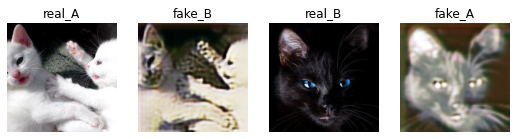

Epoch - 11
TRAIN - loss_G: 6.0331, loss_G_identity: 1.5099, loss_G_GAN: 1.3015, loss_G_cycle: 3.2217, loss_D: 0.2034
TEST -  loss_G: 6.6311, loss_G_identity: 1.7784, loss_G_GAN: 1.2803, loss_G_cycle: 3.5724, loss_D: 0.2401
Epoch - 12
TRAIN - loss_G: 6.2712, loss_G_identity: 1.6196, loss_G_GAN: 1.3091, loss_G_cycle: 3.3426, loss_D: 0.2077
TEST -  loss_G: 7.1468, loss_G_identity: 1.7666, loss_G_GAN: 1.7476, loss_G_cycle: 3.6326, loss_D: 0.2259
Epoch - 13
TRAIN - loss_G: 6.2076, loss_G_identity: 1.5615, loss_G_GAN: 1.3227, loss_G_cycle: 3.3234, loss_D: 0.2010
TEST -  loss_G: 6.1886, loss_G_identity: 1.7767, loss_G_GAN: 1.2148, loss_G_cycle: 3.1971, loss_D: 0.2537
Epoch - 14
TRAIN - loss_G: 6.3501, loss_G_identity: 1.5946, loss_G_GAN: 1.3295, loss_G_cycle: 3.4260, loss_D: 0.2077
TEST -  loss_G: 6.3754, loss_G_identity: 1.6250, loss_G_GAN: 1.2293, loss_G_cycle: 3.5211, loss_D: 0.2961
Epoch - 15
TRAIN - loss_G: 5.9468, loss_G_identity: 1.4727, loss_G_GAN: 1.2862, loss_G_cycle: 3.1880, loss_D

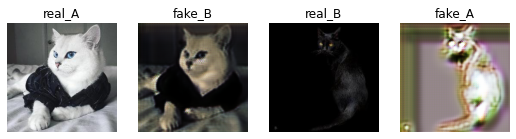

Epoch - 21
TRAIN - loss_G: 5.8717, loss_G_identity: 1.4666, loss_G_GAN: 1.2726, loss_G_cycle: 3.1325, loss_D: 0.1966
TEST -  loss_G: 6.7168, loss_G_identity: 1.6729, loss_G_GAN: 1.3775, loss_G_cycle: 3.6664, loss_D: 0.2994
Epoch - 22
TRAIN - loss_G: 5.7593, loss_G_identity: 1.4401, loss_G_GAN: 1.2588, loss_G_cycle: 3.0605, loss_D: 0.1977
TEST -  loss_G: 6.5922, loss_G_identity: 1.4871, loss_G_GAN: 1.4200, loss_G_cycle: 3.6851, loss_D: 0.2365
Epoch - 23
TRAIN - loss_G: 5.6245, loss_G_identity: 1.4023, loss_G_GAN: 1.2914, loss_G_cycle: 2.9308, loss_D: 0.1938
TEST -  loss_G: 6.2890, loss_G_identity: 1.5627, loss_G_GAN: 1.3957, loss_G_cycle: 3.3306, loss_D: 0.4032
Epoch - 24
TRAIN - loss_G: 5.6890, loss_G_identity: 1.4030, loss_G_GAN: 1.2864, loss_G_cycle: 2.9996, loss_D: 0.2090
TEST -  loss_G: 5.5903, loss_G_identity: 1.5811, loss_G_GAN: 0.7478, loss_G_cycle: 3.2614, loss_D: 0.3554
Epoch - 25
TRAIN - loss_G: 5.5923, loss_G_identity: 1.4072, loss_G_GAN: 1.2338, loss_G_cycle: 2.9513, loss_D

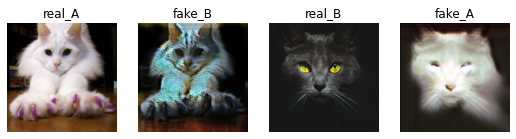

Epoch - 31
TRAIN - loss_G: 5.6054, loss_G_identity: 1.3582, loss_G_GAN: 1.2107, loss_G_cycle: 3.0365, loss_D: 0.2069
TEST -  loss_G: 6.1096, loss_G_identity: 1.5142, loss_G_GAN: 1.0893, loss_G_cycle: 3.5060, loss_D: 0.3765
Epoch - 32
TRAIN - loss_G: 5.7141, loss_G_identity: 1.3850, loss_G_GAN: 1.2250, loss_G_cycle: 3.1040, loss_D: 0.2485
TEST -  loss_G: 6.0113, loss_G_identity: 1.4126, loss_G_GAN: 1.1377, loss_G_cycle: 3.4610, loss_D: 0.3191
Epoch - 33
TRAIN - loss_G: 5.4780, loss_G_identity: 1.3170, loss_G_GAN: 1.2460, loss_G_cycle: 2.9150, loss_D: 0.1891
TEST -  loss_G: 5.4614, loss_G_identity: 1.5705, loss_G_GAN: 0.8745, loss_G_cycle: 3.0165, loss_D: 0.3989
Epoch - 34
TRAIN - loss_G: 5.2874, loss_G_identity: 1.3065, loss_G_GAN: 1.1565, loss_G_cycle: 2.8244, loss_D: 0.2271
TEST -  loss_G: 6.2174, loss_G_identity: 1.4919, loss_G_GAN: 1.4826, loss_G_cycle: 3.2429, loss_D: 0.4309
Epoch - 35
TRAIN - loss_G: 5.3694, loss_G_identity: 1.3186, loss_G_GAN: 1.1776, loss_G_cycle: 2.8732, loss_D

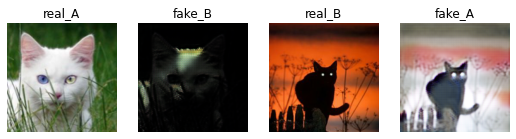

Epoch - 41
TRAIN - loss_G: 5.0952, loss_G_identity: 1.2194, loss_G_GAN: 1.1333, loss_G_cycle: 2.7425, loss_D: 0.2211
TEST -  loss_G: 5.5218, loss_G_identity: 1.4995, loss_G_GAN: 1.0150, loss_G_cycle: 3.0073, loss_D: 0.2814
Epoch - 42
TRAIN - loss_G: 4.9334, loss_G_identity: 1.1432, loss_G_GAN: 1.1538, loss_G_cycle: 2.6364, loss_D: 0.2343
TEST -  loss_G: 5.1059, loss_G_identity: 1.3281, loss_G_GAN: 1.0790, loss_G_cycle: 2.6988, loss_D: 0.4308
Epoch - 43
TRAIN - loss_G: 5.0218, loss_G_identity: 1.1862, loss_G_GAN: 1.1648, loss_G_cycle: 2.6707, loss_D: 0.2175
TEST -  loss_G: 6.9827, loss_G_identity: 1.3903, loss_G_GAN: 1.7617, loss_G_cycle: 3.8306, loss_D: 0.2387
Epoch - 44
TRAIN - loss_G: 4.9829, loss_G_identity: 1.1533, loss_G_GAN: 1.1708, loss_G_cycle: 2.6587, loss_D: 0.2014
TEST -  loss_G: 5.2837, loss_G_identity: 1.3847, loss_G_GAN: 0.9160, loss_G_cycle: 2.9829, loss_D: 0.2952
Epoch - 45
TRAIN - loss_G: 4.9530, loss_G_identity: 1.1449, loss_G_GAN: 1.1870, loss_G_cycle: 2.6211, loss_D

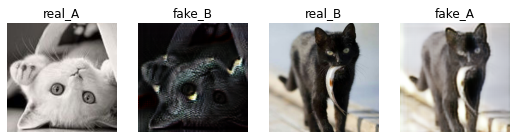

Epoch - 51
TRAIN - loss_G: 4.8225, loss_G_identity: 1.0901, loss_G_GAN: 1.1796, loss_G_cycle: 2.5528, loss_D: 0.2098
TEST -  loss_G: 5.7882, loss_G_identity: 1.4027, loss_G_GAN: 0.8138, loss_G_cycle: 3.5717, loss_D: 0.3611
Epoch - 52
TRAIN - loss_G: 4.9513, loss_G_identity: 1.0917, loss_G_GAN: 1.2319, loss_G_cycle: 2.6277, loss_D: 0.1796
TEST -  loss_G: 6.1620, loss_G_identity: 1.4378, loss_G_GAN: 1.1970, loss_G_cycle: 3.5271, loss_D: 0.3223
Epoch - 53
TRAIN - loss_G: 5.4046, loss_G_identity: 1.1560, loss_G_GAN: 1.3564, loss_G_cycle: 2.8921, loss_D: 0.1733
TEST -  loss_G: 5.9895, loss_G_identity: 1.3610, loss_G_GAN: 1.6297, loss_G_cycle: 2.9989, loss_D: 0.4426
Epoch - 54
TRAIN - loss_G: 4.6584, loss_G_identity: 1.0392, loss_G_GAN: 1.1557, loss_G_cycle: 2.4635, loss_D: 0.1927
TEST -  loss_G: 5.3853, loss_G_identity: 1.3532, loss_G_GAN: 1.0313, loss_G_cycle: 3.0007, loss_D: 0.3836
Epoch - 55
TRAIN - loss_G: 4.8960, loss_G_identity: 1.0907, loss_G_GAN: 1.2395, loss_G_cycle: 2.5658, loss_D

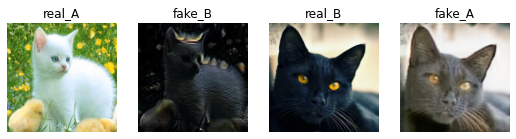

Epoch - 61
TRAIN - loss_G: 4.6031, loss_G_identity: 0.9806, loss_G_GAN: 1.1185, loss_G_cycle: 2.5040, loss_D: 0.2017
TEST -  loss_G: 6.0252, loss_G_identity: 1.3694, loss_G_GAN: 1.3299, loss_G_cycle: 3.3259, loss_D: 0.4091
Epoch - 62
TRAIN - loss_G: 4.5946, loss_G_identity: 0.9820, loss_G_GAN: 1.1588, loss_G_cycle: 2.4538, loss_D: 0.1936
TEST -  loss_G: 6.1147, loss_G_identity: 1.2271, loss_G_GAN: 2.0510, loss_G_cycle: 2.8367, loss_D: 0.7039
Epoch - 63
TRAIN - loss_G: 4.4862, loss_G_identity: 0.9453, loss_G_GAN: 1.1883, loss_G_cycle: 2.3526, loss_D: 0.2107
TEST -  loss_G: 4.6752, loss_G_identity: 1.2927, loss_G_GAN: 0.8918, loss_G_cycle: 2.4907, loss_D: 0.3726
Epoch - 64
TRAIN - loss_G: 4.5211, loss_G_identity: 0.9538, loss_G_GAN: 1.1749, loss_G_cycle: 2.3924, loss_D: 0.2150
TEST -  loss_G: 5.7641, loss_G_identity: 1.2370, loss_G_GAN: 1.4842, loss_G_cycle: 3.0429, loss_D: 0.4088
Epoch - 65
TRAIN - loss_G: 4.4859, loss_G_identity: 0.9656, loss_G_GAN: 1.1210, loss_G_cycle: 2.3992, loss_D

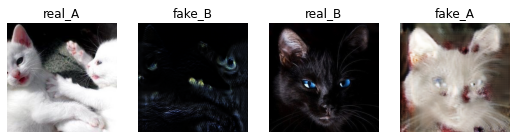

Epoch - 71
TRAIN - loss_G: 4.3193, loss_G_identity: 0.9068, loss_G_GAN: 1.1048, loss_G_cycle: 2.3077, loss_D: 0.2035
TEST -  loss_G: 5.6752, loss_G_identity: 1.2929, loss_G_GAN: 1.3109, loss_G_cycle: 3.0714, loss_D: 0.5107
Epoch - 72
TRAIN - loss_G: 4.5218, loss_G_identity: 0.9373, loss_G_GAN: 1.2051, loss_G_cycle: 2.3794, loss_D: 0.2144
TEST -  loss_G: 5.3358, loss_G_identity: 1.4813, loss_G_GAN: 1.0024, loss_G_cycle: 2.8521, loss_D: 0.3846
Epoch - 73
TRAIN - loss_G: 4.6729, loss_G_identity: 0.9966, loss_G_GAN: 1.2941, loss_G_cycle: 2.3823, loss_D: 0.1702
TEST -  loss_G: 5.4385, loss_G_identity: 1.4270, loss_G_GAN: 1.1328, loss_G_cycle: 2.8786, loss_D: 0.3594
Epoch - 74
TRAIN - loss_G: 4.2704, loss_G_identity: 0.8763, loss_G_GAN: 1.1733, loss_G_cycle: 2.2207, loss_D: 0.2160
TEST -  loss_G: 5.0856, loss_G_identity: 1.2494, loss_G_GAN: 0.9089, loss_G_cycle: 2.9273, loss_D: 0.3623
Epoch - 75
TRAIN - loss_G: 4.2938, loss_G_identity: 0.8928, loss_G_GAN: 1.1538, loss_G_cycle: 2.2472, loss_D

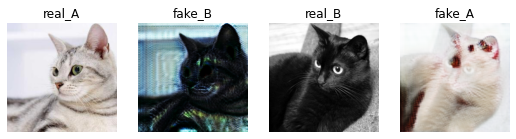

Epoch - 81
TRAIN - loss_G: 4.2775, loss_G_identity: 0.8677, loss_G_GAN: 1.1718, loss_G_cycle: 2.2380, loss_D: 0.2208
TEST -  loss_G: 5.2643, loss_G_identity: 1.3788, loss_G_GAN: 1.0006, loss_G_cycle: 2.8849, loss_D: 0.4475
Epoch - 82
TRAIN - loss_G: 4.1478, loss_G_identity: 0.8296, loss_G_GAN: 1.1570, loss_G_cycle: 2.1612, loss_D: 0.1997
TEST -  loss_G: 4.9336, loss_G_identity: 1.2570, loss_G_GAN: 1.0167, loss_G_cycle: 2.6600, loss_D: 0.4185
Epoch - 83
TRAIN - loss_G: 4.1332, loss_G_identity: 0.8400, loss_G_GAN: 1.1524, loss_G_cycle: 2.1409, loss_D: 0.2012
TEST -  loss_G: 4.9226, loss_G_identity: 1.2461, loss_G_GAN: 0.8849, loss_G_cycle: 2.7915, loss_D: 0.5690
Epoch - 84
TRAIN - loss_G: 4.1157, loss_G_identity: 0.8375, loss_G_GAN: 1.1449, loss_G_cycle: 2.1334, loss_D: 0.2203
TEST -  loss_G: 5.0959, loss_G_identity: 1.3303, loss_G_GAN: 1.0108, loss_G_cycle: 2.7548, loss_D: 0.4818
Epoch - 85
TRAIN - loss_G: 4.0391, loss_G_identity: 0.8097, loss_G_GAN: 1.1417, loss_G_cycle: 2.0877, loss_D

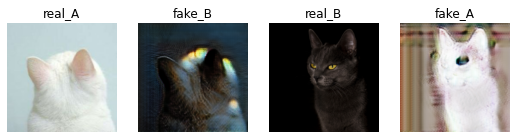

Epoch - 91
TRAIN - loss_G: 4.1300, loss_G_identity: 0.8346, loss_G_GAN: 1.1710, loss_G_cycle: 2.1245, loss_D: 0.2106
TEST -  loss_G: 4.9998, loss_G_identity: 1.2138, loss_G_GAN: 0.9937, loss_G_cycle: 2.7923, loss_D: 0.4682
Epoch - 92
TRAIN - loss_G: 4.2492, loss_G_identity: 0.8412, loss_G_GAN: 1.2240, loss_G_cycle: 2.1840, loss_D: 0.1961
TEST -  loss_G: 5.1622, loss_G_identity: 1.2931, loss_G_GAN: 1.0546, loss_G_cycle: 2.8145, loss_D: 0.5612
Epoch - 93
TRAIN - loss_G: 4.1008, loss_G_identity: 0.8089, loss_G_GAN: 1.2092, loss_G_cycle: 2.0828, loss_D: 0.1761
TEST -  loss_G: 5.5924, loss_G_identity: 1.2627, loss_G_GAN: 1.2375, loss_G_cycle: 3.0922, loss_D: 0.4815
Epoch - 94
TRAIN - loss_G: 4.0279, loss_G_identity: 0.7904, loss_G_GAN: 1.1704, loss_G_cycle: 2.0672, loss_D: 0.2251
TEST -  loss_G: 5.4627, loss_G_identity: 1.2678, loss_G_GAN: 1.4939, loss_G_cycle: 2.7009, loss_D: 0.5396
Epoch - 95
TRAIN - loss_G: 4.1814, loss_G_identity: 0.8309, loss_G_GAN: 1.1889, loss_G_cycle: 2.1617, loss_D

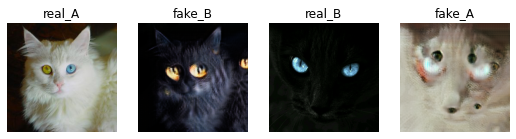

Epoch - 101
TRAIN - loss_G: 4.0465, loss_G_identity: 0.7768, loss_G_GAN: 1.2244, loss_G_cycle: 2.0453, loss_D: 0.1852
TEST -  loss_G: 4.9101, loss_G_identity: 1.3229, loss_G_GAN: 1.1139, loss_G_cycle: 2.4733, loss_D: 0.5256
Epoch - 102
TRAIN - loss_G: 3.9641, loss_G_identity: 0.7644, loss_G_GAN: 1.1804, loss_G_cycle: 2.0193, loss_D: 0.2008
TEST -  loss_G: 5.9851, loss_G_identity: 1.3179, loss_G_GAN: 1.5340, loss_G_cycle: 3.1331, loss_D: 0.6207
Epoch - 103
TRAIN - loss_G: 4.0012, loss_G_identity: 0.7615, loss_G_GAN: 1.2092, loss_G_cycle: 2.0305, loss_D: 0.2090
TEST -  loss_G: 5.5662, loss_G_identity: 1.1477, loss_G_GAN: 1.7742, loss_G_cycle: 2.6443, loss_D: 0.6971
Epoch - 104
TRAIN - loss_G: 3.9666, loss_G_identity: 0.7634, loss_G_GAN: 1.1716, loss_G_cycle: 2.0316, loss_D: 0.2083
TEST -  loss_G: 5.0231, loss_G_identity: 1.3469, loss_G_GAN: 1.0469, loss_G_cycle: 2.6293, loss_D: 0.4321
Epoch - 105
TRAIN - loss_G: 4.1236, loss_G_identity: 0.7706, loss_G_GAN: 1.2628, loss_G_cycle: 2.0901, l

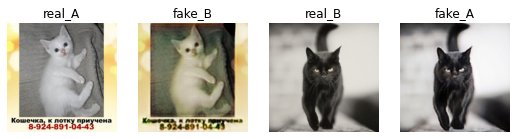

Epoch - 111
TRAIN - loss_G: 3.9783, loss_G_identity: 0.7515, loss_G_GAN: 1.2321, loss_G_cycle: 1.9946, loss_D: 0.1858
TEST -  loss_G: 5.2414, loss_G_identity: 1.1842, loss_G_GAN: 1.5331, loss_G_cycle: 2.5241, loss_D: 0.6228
Epoch - 112
TRAIN - loss_G: 3.8768, loss_G_identity: 0.7279, loss_G_GAN: 1.1824, loss_G_cycle: 1.9665, loss_D: 0.1776
TEST -  loss_G: 4.8514, loss_G_identity: 1.1455, loss_G_GAN: 1.0897, loss_G_cycle: 2.6163, loss_D: 0.4890
Epoch - 113
TRAIN - loss_G: 3.8753, loss_G_identity: 0.7252, loss_G_GAN: 1.1753, loss_G_cycle: 1.9748, loss_D: 0.1690
TEST -  loss_G: 5.5714, loss_G_identity: 1.4523, loss_G_GAN: 1.4074, loss_G_cycle: 2.7117, loss_D: 0.5782
Epoch - 114
TRAIN - loss_G: 3.7860, loss_G_identity: 0.6929, loss_G_GAN: 1.1874, loss_G_cycle: 1.9057, loss_D: 0.1844
TEST -  loss_G: 4.5937, loss_G_identity: 1.2282, loss_G_GAN: 0.7363, loss_G_cycle: 2.6292, loss_D: 0.4068
Epoch - 115
TRAIN - loss_G: 3.9324, loss_G_identity: 0.7318, loss_G_GAN: 1.2499, loss_G_cycle: 1.9507, l

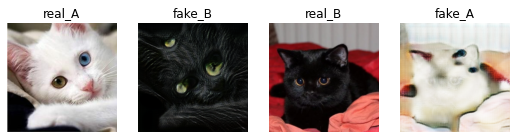

Epoch - 121
TRAIN - loss_G: 3.8173, loss_G_identity: 0.6874, loss_G_GAN: 1.2362, loss_G_cycle: 1.8937, loss_D: 0.1540
TEST -  loss_G: 5.1356, loss_G_identity: 1.2808, loss_G_GAN: 1.2866, loss_G_cycle: 2.5682, loss_D: 0.4990
Epoch - 122
TRAIN - loss_G: 3.8932, loss_G_identity: 0.6932, loss_G_GAN: 1.2669, loss_G_cycle: 1.9330, loss_D: 0.1575
TEST -  loss_G: 5.2826, loss_G_identity: 1.5207, loss_G_GAN: 0.8589, loss_G_cycle: 2.9030, loss_D: 0.5054
Epoch - 123
TRAIN - loss_G: 3.7629, loss_G_identity: 0.6857, loss_G_GAN: 1.1956, loss_G_cycle: 1.8817, loss_D: 0.1559
TEST -  loss_G: 5.1806, loss_G_identity: 1.3283, loss_G_GAN: 1.2214, loss_G_cycle: 2.6308, loss_D: 0.4196
Epoch - 124
TRAIN - loss_G: 3.7545, loss_G_identity: 0.6857, loss_G_GAN: 1.2043, loss_G_cycle: 1.8646, loss_D: 0.1546
TEST -  loss_G: 4.9839, loss_G_identity: 1.3525, loss_G_GAN: 0.9067, loss_G_cycle: 2.7247, loss_D: 0.3668
Epoch - 125
TRAIN - loss_G: 3.8826, loss_G_identity: 0.6896, loss_G_GAN: 1.2992, loss_G_cycle: 1.8939, l

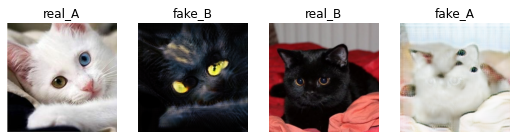

Epoch - 131
TRAIN - loss_G: 3.6973, loss_G_identity: 0.6533, loss_G_GAN: 1.2098, loss_G_cycle: 1.8341, loss_D: 0.1494
TEST -  loss_G: 5.2058, loss_G_identity: 1.1548, loss_G_GAN: 1.5385, loss_G_cycle: 2.5125, loss_D: 0.6413
Epoch - 132
TRAIN - loss_G: 3.5449, loss_G_identity: 0.6251, loss_G_GAN: 1.1907, loss_G_cycle: 1.7291, loss_D: 0.1649
TEST -  loss_G: 4.8232, loss_G_identity: 1.2742, loss_G_GAN: 1.0205, loss_G_cycle: 2.5285, loss_D: 0.4499
Epoch - 133
TRAIN - loss_G: 3.7338, loss_G_identity: 0.6400, loss_G_GAN: 1.2531, loss_G_cycle: 1.8408, loss_D: 0.1516
TEST -  loss_G: 5.2220, loss_G_identity: 1.4020, loss_G_GAN: 1.1502, loss_G_cycle: 2.6698, loss_D: 0.5295
Epoch - 134
TRAIN - loss_G: 3.6861, loss_G_identity: 0.6345, loss_G_GAN: 1.2538, loss_G_cycle: 1.7978, loss_D: 0.1439
TEST -  loss_G: 5.3556, loss_G_identity: 1.3198, loss_G_GAN: 1.4848, loss_G_cycle: 2.5510, loss_D: 0.6122
Epoch - 135
TRAIN - loss_G: 3.5221, loss_G_identity: 0.6144, loss_G_GAN: 1.1686, loss_G_cycle: 1.7391, l

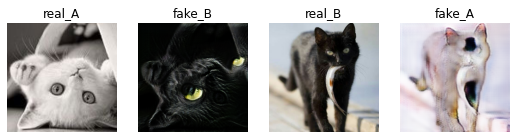

Epoch - 141
TRAIN - loss_G: 3.5241, loss_G_identity: 0.5947, loss_G_GAN: 1.2332, loss_G_cycle: 1.6962, loss_D: 0.1432
TEST -  loss_G: 5.9132, loss_G_identity: 1.3971, loss_G_GAN: 1.8407, loss_G_cycle: 2.6754, loss_D: 0.6127
Epoch - 142
TRAIN - loss_G: 3.4549, loss_G_identity: 0.5945, loss_G_GAN: 1.1937, loss_G_cycle: 1.6668, loss_D: 0.1442
TEST -  loss_G: 4.7525, loss_G_identity: 1.3107, loss_G_GAN: 0.9076, loss_G_cycle: 2.5342, loss_D: 0.5801
Epoch - 143
TRAIN - loss_G: 3.5721, loss_G_identity: 0.6203, loss_G_GAN: 1.2141, loss_G_cycle: 1.7377, loss_D: 0.1494
TEST -  loss_G: 6.1862, loss_G_identity: 1.4128, loss_G_GAN: 1.9691, loss_G_cycle: 2.8044, loss_D: 0.6832
Epoch - 144
TRAIN - loss_G: 3.6185, loss_G_identity: 0.6119, loss_G_GAN: 1.2601, loss_G_cycle: 1.7464, loss_D: 0.1356
TEST -  loss_G: 5.7216, loss_G_identity: 1.3610, loss_G_GAN: 1.6876, loss_G_cycle: 2.6730, loss_D: 0.6662
Epoch - 145
TRAIN - loss_G: 3.5824, loss_G_identity: 0.5970, loss_G_GAN: 1.2582, loss_G_cycle: 1.7272, l

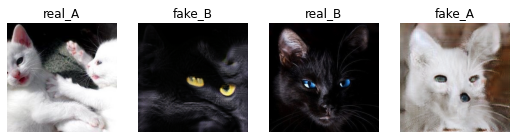

Epoch - 151
TRAIN - loss_G: 3.4336, loss_G_identity: 0.5629, loss_G_GAN: 1.2377, loss_G_cycle: 1.6330, loss_D: 0.1266
TEST -  loss_G: 5.7265, loss_G_identity: 1.3133, loss_G_GAN: 1.7752, loss_G_cycle: 2.6380, loss_D: 0.6415
Epoch - 152
TRAIN - loss_G: 3.4863, loss_G_identity: 0.5692, loss_G_GAN: 1.2703, loss_G_cycle: 1.6468, loss_D: 0.1389
TEST -  loss_G: 5.3972, loss_G_identity: 1.2452, loss_G_GAN: 1.5824, loss_G_cycle: 2.5697, loss_D: 0.6783
Epoch - 153
TRAIN - loss_G: 3.3827, loss_G_identity: 0.5530, loss_G_GAN: 1.2447, loss_G_cycle: 1.5850, loss_D: 0.1337
TEST -  loss_G: 5.3470, loss_G_identity: 1.2157, loss_G_GAN: 1.4970, loss_G_cycle: 2.6343, loss_D: 0.6310
Epoch - 154
TRAIN - loss_G: 3.4127, loss_G_identity: 0.5569, loss_G_GAN: 1.2576, loss_G_cycle: 1.5981, loss_D: 0.1319
TEST -  loss_G: 5.3494, loss_G_identity: 1.2330, loss_G_GAN: 1.4903, loss_G_cycle: 2.6261, loss_D: 0.5396
Epoch - 155
TRAIN - loss_G: 3.3351, loss_G_identity: 0.5402, loss_G_GAN: 1.2331, loss_G_cycle: 1.5618, l

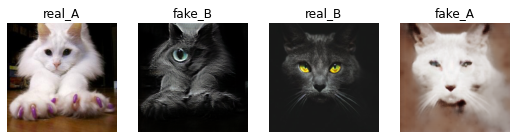

Epoch - 161
TRAIN - loss_G: 3.3336, loss_G_identity: 0.5371, loss_G_GAN: 1.2461, loss_G_cycle: 1.5504, loss_D: 0.1274
TEST -  loss_G: 5.9531, loss_G_identity: 1.3375, loss_G_GAN: 2.0921, loss_G_cycle: 2.5235, loss_D: 0.7853
Epoch - 162
TRAIN - loss_G: 3.4459, loss_G_identity: 0.5426, loss_G_GAN: 1.3085, loss_G_cycle: 1.5948, loss_D: 0.1158
TEST -  loss_G: 5.5799, loss_G_identity: 1.3416, loss_G_GAN: 1.7051, loss_G_cycle: 2.5332, loss_D: 0.7094
Epoch - 163
TRAIN - loss_G: 3.4015, loss_G_identity: 0.5500, loss_G_GAN: 1.2476, loss_G_cycle: 1.6038, loss_D: 0.1313
TEST -  loss_G: 5.4508, loss_G_identity: 1.3519, loss_G_GAN: 1.8193, loss_G_cycle: 2.2796, loss_D: 0.7063
Epoch - 164
TRAIN - loss_G: 3.3609, loss_G_identity: 0.5356, loss_G_GAN: 1.2657, loss_G_cycle: 1.5596, loss_D: 0.1185
TEST -  loss_G: 5.4664, loss_G_identity: 1.3141, loss_G_GAN: 1.5559, loss_G_cycle: 2.5964, loss_D: 0.6778
Epoch - 165
TRAIN - loss_G: 3.2727, loss_G_identity: 0.5088, loss_G_GAN: 1.2609, loss_G_cycle: 1.5030, l

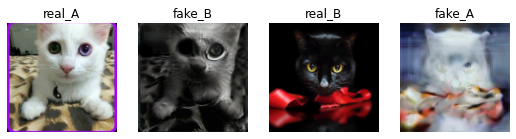

Epoch - 171
TRAIN - loss_G: 3.2489, loss_G_identity: 0.5072, loss_G_GAN: 1.2571, loss_G_cycle: 1.4846, loss_D: 0.1252
TEST -  loss_G: 6.0689, loss_G_identity: 1.3643, loss_G_GAN: 1.9784, loss_G_cycle: 2.7262, loss_D: 0.7349
Epoch - 172
TRAIN - loss_G: 3.1989, loss_G_identity: 0.4904, loss_G_GAN: 1.2678, loss_G_cycle: 1.4407, loss_D: 0.1258
TEST -  loss_G: 5.6748, loss_G_identity: 1.2776, loss_G_GAN: 1.8311, loss_G_cycle: 2.5660, loss_D: 0.6558
Epoch - 173
TRAIN - loss_G: 3.1875, loss_G_identity: 0.4877, loss_G_GAN: 1.2831, loss_G_cycle: 1.4166, loss_D: 0.1175
TEST -  loss_G: 6.0085, loss_G_identity: 1.3837, loss_G_GAN: 2.2207, loss_G_cycle: 2.4041, loss_D: 0.8645
Epoch - 174
TRAIN - loss_G: 3.1567, loss_G_identity: 0.4877, loss_G_GAN: 1.2694, loss_G_cycle: 1.3997, loss_D: 0.1181
TEST -  loss_G: 5.7456, loss_G_identity: 1.3554, loss_G_GAN: 1.9320, loss_G_cycle: 2.4583, loss_D: 0.8475
Epoch - 175
TRAIN - loss_G: 3.2648, loss_G_identity: 0.5026, loss_G_GAN: 1.2916, loss_G_cycle: 1.4706, l

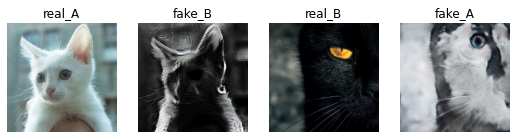

Epoch - 181
TRAIN - loss_G: 3.1074, loss_G_identity: 0.4679, loss_G_GAN: 1.2819, loss_G_cycle: 1.3576, loss_D: 0.1136
TEST -  loss_G: 6.1308, loss_G_identity: 1.3982, loss_G_GAN: 2.2058, loss_G_cycle: 2.5268, loss_D: 0.8828
Epoch - 182
TRAIN - loss_G: 3.0807, loss_G_identity: 0.4823, loss_G_GAN: 1.2144, loss_G_cycle: 1.3840, loss_D: 0.1236
TEST -  loss_G: 6.1137, loss_G_identity: 1.3995, loss_G_GAN: 2.2294, loss_G_cycle: 2.4848, loss_D: 0.9260
Epoch - 183
TRAIN - loss_G: 3.1215, loss_G_identity: 0.4739, loss_G_GAN: 1.2772, loss_G_cycle: 1.3703, loss_D: 0.1125
TEST -  loss_G: 6.1913, loss_G_identity: 1.3664, loss_G_GAN: 2.4292, loss_G_cycle: 2.3957, loss_D: 0.9701
Epoch - 184
TRAIN - loss_G: 3.1160, loss_G_identity: 0.4789, loss_G_GAN: 1.2564, loss_G_cycle: 1.3808, loss_D: 0.1186
TEST -  loss_G: 6.3466, loss_G_identity: 1.4381, loss_G_GAN: 2.3110, loss_G_cycle: 2.5975, loss_D: 0.9129
Epoch - 185
TRAIN - loss_G: 3.1366, loss_G_identity: 0.4836, loss_G_GAN: 1.2659, loss_G_cycle: 1.3872, l

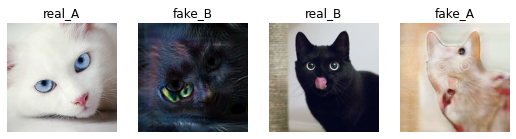

Epoch - 191
TRAIN - loss_G: 3.0043, loss_G_identity: 0.4515, loss_G_GAN: 1.2481, loss_G_cycle: 1.3047, loss_D: 0.1175
TEST -  loss_G: 6.4363, loss_G_identity: 1.3850, loss_G_GAN: 2.5171, loss_G_cycle: 2.5342, loss_D: 0.9726
Epoch - 192
TRAIN - loss_G: 3.0556, loss_G_identity: 0.4619, loss_G_GAN: 1.2592, loss_G_cycle: 1.3346, loss_D: 0.1131
TEST -  loss_G: 6.5350, loss_G_identity: 1.3678, loss_G_GAN: 2.7348, loss_G_cycle: 2.4324, loss_D: 1.0100
Epoch - 193
TRAIN - loss_G: 3.0250, loss_G_identity: 0.4600, loss_G_GAN: 1.2502, loss_G_cycle: 1.3149, loss_D: 0.1179
TEST -  loss_G: 6.6796, loss_G_identity: 1.3950, loss_G_GAN: 2.6935, loss_G_cycle: 2.5911, loss_D: 1.0086
Epoch - 194
TRAIN - loss_G: 3.0320, loss_G_identity: 0.4597, loss_G_GAN: 1.2613, loss_G_cycle: 1.3110, loss_D: 0.1153
TEST -  loss_G: 6.5987, loss_G_identity: 1.3310, loss_G_GAN: 2.8825, loss_G_cycle: 2.3852, loss_D: 1.1444
Epoch - 195
TRAIN - loss_G: 3.0200, loss_G_identity: 0.4620, loss_G_GAN: 1.2611, loss_G_cycle: 1.2969, l

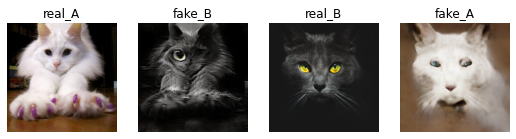

CPU times: user 1h 46min 30s, sys: 1h 8min 19s, total: 2h 54min 50s
Wall time: 2h 58min 9s


In [ ]:
%%time
train_loop(from_checkpoint=False)

### Losses
Посмотрим, как выглядят трейн и тест лоссы на обучении

In [ ]:
logs = {}
for mode in ["train", "test"]:
    with open(f"output/{output_name}/{mode}_log.json", "r") as file:
        logs[mode] = json.load(file)

In [ ]:
def plot_logs(train_log: dict, test_log: dict):
    for loss_name in train_log:
        plt.style.use('ggplot')
        plt.figure(figsize=(9, 6))
        plt.plot(train_log[loss_name], label="train")
        plt.plot(test_log[loss_name], label="test")
        plt.title(loss_name)
        plt.legend()
        plt.show()

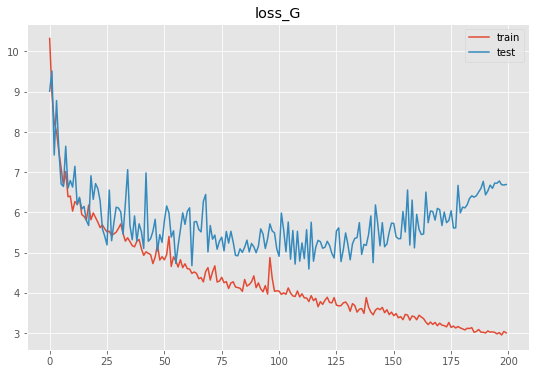

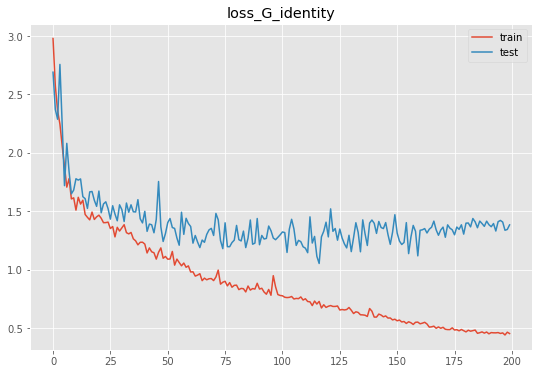

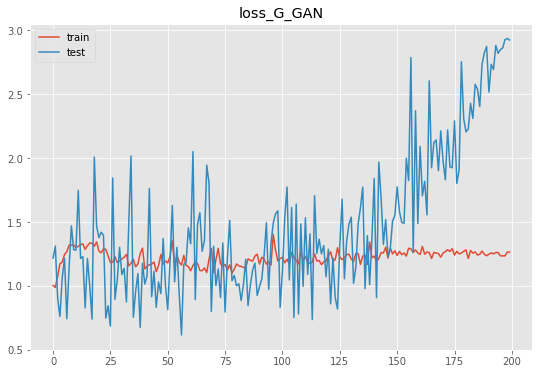

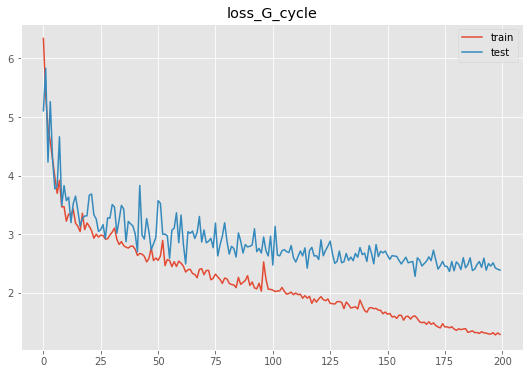

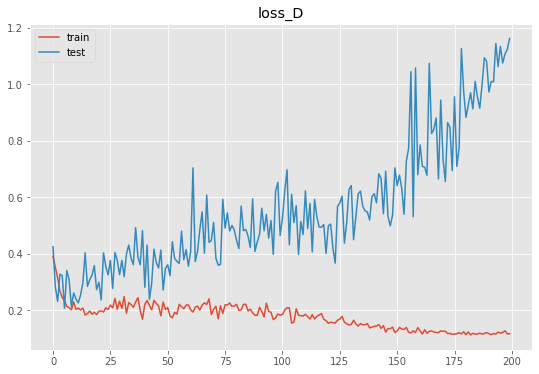

In [ ]:
plot_logs(logs["train"], logs["test"])

## <center>Применение (тестирование) обученных и сохраненных генераторов

инициализация параметров для теста

In [ ]:
# test params init
batchSize = 1  # size of the batches
dataroot = f'datasets/{dataset_name}/'  # root directory of the dataset
input_nc = 3  # number of channels of input data
output_nc = 3  # number of channels of output data
n_cpu = 8  # number of cpu threads to use during batch generation
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

инициализация моделей генераторов и загрузчика данных

In [ ]:
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

netG_A2B_path = f'output/{output_name}/best/netG_A2B.pth'
netG_B2A_path = f'output/{output_name}/best/netG_B2A.pth'

# load state dicts
netG_A2B.load_state_dict(torch.load(netG_A2B_path, map_location=device))
netG_B2A.load_state_dict(torch.load(netG_B2A_path, map_location=device))

# set test mode
netG_A2B.eval()
netG_B2A.eval()

# Dataset loader
test_transforms = [transforms.ToTensor(),
                   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
test_dataloader = DataLoader(ImageDataset(dataroot, transforms_=test_transforms, mode='test'), 
                        batch_size=batchSize, shuffle=False, num_workers=n_cpu)

применяем генераторы к тестовой выборке и сохраняем результат (вместе с оригиналами)

In [ ]:
# Create output dirs if they don't exist
if not os.path.exists(f'output/{output_name}/A'):
    os.makedirs(f'output/{output_name}/A')
if not os.path.exists(f'output/{output_name}/B'):
    os.makedirs(f'output/{output_name}/B')

for i, batch in enumerate(test_dataloader):
    # Set model input
    real_A = batch['A']
    real_B = batch['B']

    real_A_img = 0.5* (real_A.data + 1.0)
    real_B_img = 0.5* (real_B.data + 1.0)
    
    # Generate output
    fake_A2B_img = 0.5*(netG_A2B(real_A.to(device)).data + 1.0)
    fake_B2A_img = 0.5*(netG_B2A(real_B.to(device)).data + 1.0)

    # Save image files
    save_image(real_A_img, f'output/{output_name}/A/{i}_realA.png')
    save_image(real_B_img, f'output/{output_name}/B/{i}_realB.png')
    save_image(fake_A2B_img, f'output/{output_name}/A/{i}_fakeA2B.png')
    save_image(fake_B2A_img, f'output/{output_name}/B/{i}_fakeB2A.png')

## Визуализация результата

In [ ]:
class PlotResult:
    def __init__(self, mode="A2B", root=f"output/{output_name}"):
        self.root = root
        self.mode = mode

    def plot(self, num=4, figsize=(24, 12)):
        real_liter = self.mode[0]
        self.real_files = sorted(glob.glob(os.path.join(self.root, real_liter, f'*_real{real_liter}.png')))
        self.fake_files = sorted(glob.glob(os.path.join(self.root, real_liter, f'*_fake{self.mode}.png')))

        inds = random.choices(list(range(len(self.real_files))), k=num)

        plt.figure(figsize=figsize)
        for i, ind in enumerate(inds):
            plt.subplot(2, num, i+1)
            plt.axis("off")
            plt.imshow(Image.open(self.real_files[ind]))
            plt.title(f"real{real_liter}")

            plt.subplot(2, num, num+i+1)
            plt.axis("off")
            plt.imshow(Image.open(self.fake_files[ind]))
            plt.title(f"fake{self.mode}")
        plt.show()

Визуализация результата **A2B**   
(несколько случайных вариантов)

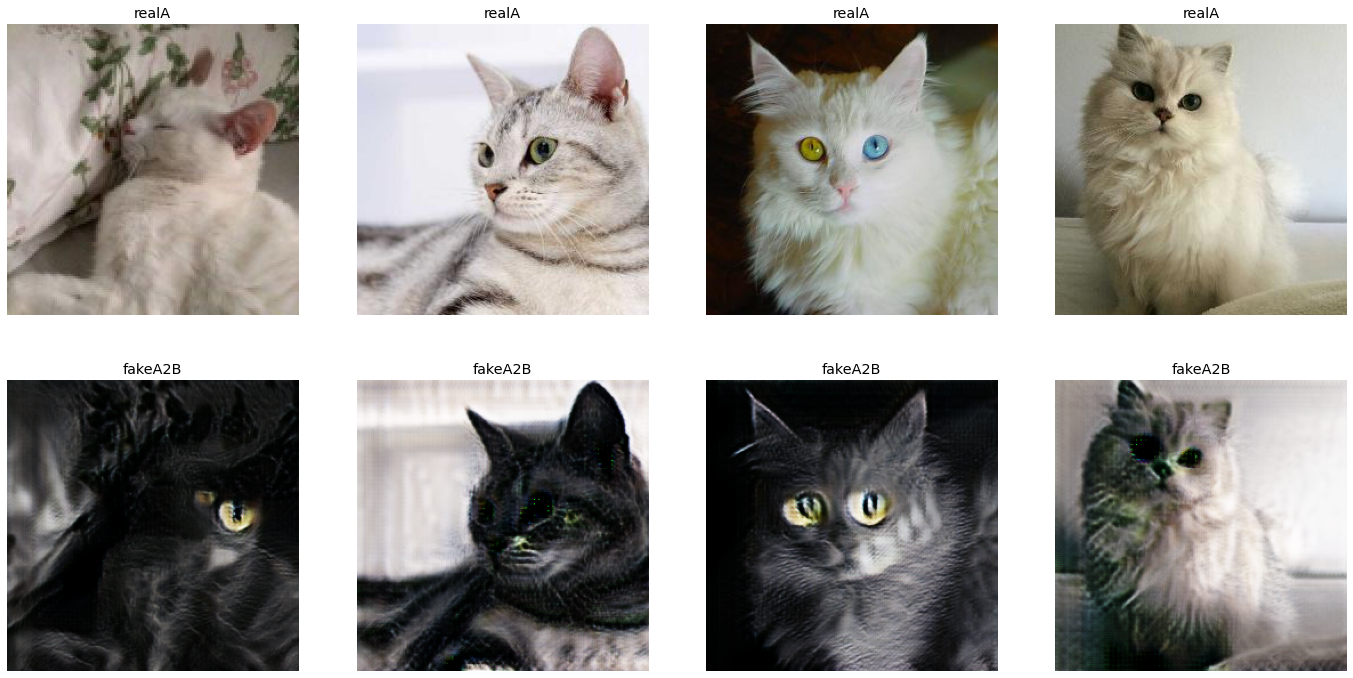

In [ ]:
PlotResult("A2B").plot()

Визуализация результата **B2A**   
(несколько случайных вариантов)

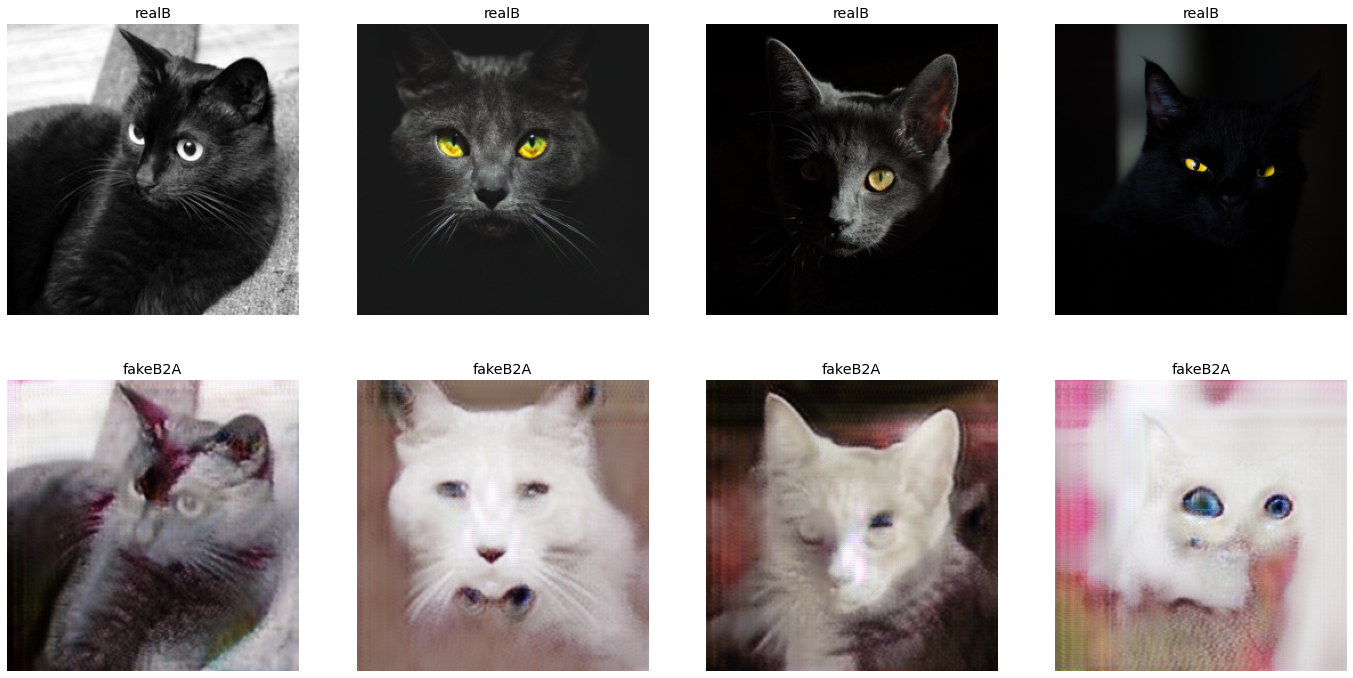

In [ ]:
PlotResult("B2A").plot()

## Некоторые выводы- видно, что модель обучается
- примерно со 125 эпохи наблюдается переобучение
- думаю, переобучение связано с недостаточным объемом датасета. В трейне было 130 изображений, в тесте - 20
- малый объем датасета связан с тем, что пришлось делать его вручную. Просто скачал коартинки руками из яндекс-картинок
- думаю, можно было бы результат улучшить, в частности, путем увеличения датасета 